<a href="https://www.kaggle.com/code/dalloliogm/pgs5e8-bank-autogluon?scriptVersionId=253675933" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Bank classification using Autogluon


Autogluon is a auto-ML library from Amazon. It can automatically try several approaches for prediction, and choose the optimal parameters given target metrics to optimize. It also automatically handles cross-validation, although that is not always enabled for all the presets.

Feel free to copy this notebook and adapt it. Some ideas on how to improve it:
- add more feature engineering
- Try different autogluon presets, or run it for longer
- Tweak the autogluon hyperparameters to add/remove more models
- Plot results and inspect them

## Install Libraries and set Configuration

Installing Autogluon takes time, on Kaggle, but once that is done, we don't need anything else.

In [1]:
# %%capture
# !pip install -U autogluon

In [2]:
%%capture
!pip install -q xgboost==1.7.6 scikit-learn==1.3.2

In [3]:
# %%capture
import os
import shutil

target_dir = "/kaggle/working/"
source_dir = "/kaggle/input/autogluon-package/"

if not os.path.exists(os.path.join(target_dir, "autogluon")):
    shutil.copytree(source_dir, target_dir, dirs_exist_ok=True)
    print("Copied autogluon installation files.")

!pip install -f --quiet --no-index --find-links='/kaggle/input/autogluon-package' 'autogluon.tabular-1.3.1-py3-none-any.whl'


Copied autogluon installation files.
Looking in links: --quiet, /kaggle/input/autogluon-package
Processing ./autogluon.tabular-1.3.1-py3-none-any.whl
Processing /kaggle/input/autogluon-package/scikit_learn-1.6.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (from autogluon.tabular==1.3.1)
Processing /kaggle/input/autogluon-package/autogluon.core-1.3.1-py3-none-any.whl (from autogluon.tabular==1.3.1)
Processing /kaggle/input/autogluon-package/autogluon.features-1.3.1-py3-none-any.whl (from autogluon.tabular==1.3.1)
Processing /kaggle/input/autogluon-package/autogluon.common-1.3.1-py3-none-any.whl (from autogluon.core==1.3.1->autogluon.tabular==1.3.1)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following 

In [4]:
# Autogluon configuration. Automatically detects if we are using an interactive notebook, and use lower defaults when debugging
import os
import pandas as pd
import numpy as np
from autogluon.tabular import TabularPredictor

def is_interactive_session():
    return os.environ.get('KAGGLE_KERNEL_RUN_TYPE','') == 'Interactive'

is_interactive_session()

config = {
    #                  minutes     seconds       # hours
    "autogluon_time": 60       *  60        *   4,
    "autogluon_preset": "best_quality",
    #"reduce_features": 0, # Set to >0 to use only the first n features
    "tail_rows": 0 # Set to >0 to use only the last n rows in the file. Useful for debugging
    
}

if is_interactive_session():
    print("Interactive session")
    config["autogluon_time"] = 100
    #config["reduce_features"] = 200
    config["autogluon_preset"] = "medium_quality"
    config["tail_rows"] = 2000
    print(config)
else:
    print("running as job")
    print(config)

running as job
{'autogluon_time': 14400, 'autogluon_preset': 'best_quality', 'tail_rows': 0}


In [5]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

### Autogluon parameters

In [6]:
hyperparameters = {
    'GBM': {},      # LightGBM
    'CAT': {},      # CatBoost
    'RF': {},       # RandomForest
    'XT': {},       # ExtraTrees
    'KNN': {},      # k-NN
    # 'NN': {},       # MXNet neural-net
    'LR': {},       # LinearModel
    'XGB': {        # XGBoost 
    },
    'TABPFN': {},
    'ENS_WEIGHTED' : {},
    'NN_TORCH': {},
    'IM_BOOSTEDRULES' : {}
}

# 'RF', 'XT', 'KNN', 'GBM', 'CAT', 'XGB', 'NN_TORCH', 'LR', 'FASTAI', 'AG_TEXT_NN', 'AG_IMAGE_NN', 
# 'AG_AUTOMM', 'FT_TRANSFORMER', 'TABPFN', 'TABPFNMIX', 'FASTTEXT', 'ENS_WEIGHTED', 'SIMPLE_ENS_WEIGHTED',
# 'IM_RULEFIT', 'IM_GREEDYTREE', 'IM_FIGS', 'IM_HSTREE', 'IM_BOOSTEDRULES', 'DUMMY']

## Load Data

In [7]:
import pandas as pd
# data
path        = '/kaggle/input/playground-series-s5e8/'
train       = pd.read_csv(path + 'train.csv',             index_col = 'id')
test        = pd.read_csv(path + 'test.csv',              index_col = 'id')
submission  = pd.read_csv(path + 'sample_submission.csv', index_col = 'id')

# Reduce dataset size for debugging
if config["tail_rows"] > 0:
    train = train.head(config["tail_rows"])

In [8]:
train.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
id,,,,,,,,,,,,,,,,,
0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0
1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0
2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0
3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0
4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown,1


In [9]:
test.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
id,,,,,,,,,,,,,,,,
750000,32,blue-collar,married,secondary,no,1397,yes,no,unknown,21,may,224,1,-1,0,unknown
750001,44,management,married,tertiary,no,23,yes,no,cellular,3,apr,586,2,-1,0,unknown
750002,36,self-employed,married,primary,no,46,yes,yes,cellular,13,may,111,2,-1,0,unknown
750003,58,blue-collar,married,secondary,no,-1380,yes,yes,unknown,29,may,125,1,-1,0,unknown
750004,28,technician,single,secondary,no,1950,yes,no,cellular,22,jul,181,1,-1,0,unknown


In [10]:
submission.head

<bound method NDFrame.head of           y
id         
750000  0.5
750001  0.5
750002  0.5
750003  0.5
750004  0.5
...     ...
999995  0.5
999996  0.5
999997  0.5
999998  0.5
999999  0.5

[250000 rows x 1 columns]>

# Set up Training

In [11]:
# 2) Fit all models under regression:
predictor = TabularPredictor(
    label='y',
    problem_type='binary',
    eval_metric="roc_auc",
).fit(
    train,
    hyperparameters=hyperparameters,
    time_limit = config["autogluon_time"],
    presets = config["autogluon_preset"]
)

No path specified. Models will be saved in: "AutogluonModels/ag-20250801_124201"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Nov 10 10:07:59 UTC 2024
CPU Count:          4
Memory Avail:       30.10 GB / 31.35 GB (96.0%)
Disk Space Avail:   16.00 GB / 19.52 GB (82.0%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be 

[1000]	valid_set's binary_logloss: 0.144571
[2000]	valid_set's binary_logloss: 0.143549
[3000]	valid_set's binary_logloss: 0.143508
[1000]	valid_set's binary_logloss: 0.14434
[2000]	valid_set's binary_logloss: 0.143396
[3000]	valid_set's binary_logloss: 0.14323
[1000]	valid_set's binary_logloss: 0.145153
[2000]	valid_set's binary_logloss: 0.144181
[1000]	valid_set's binary_logloss: 0.143304
[2000]	valid_set's binary_logloss: 0.142492
[3000]	valid_set's binary_logloss: 0.142313
[4000]	valid_set's binary_logloss: 0.142222
[1000]	valid_set's binary_logloss: 0.143693
[2000]	valid_set's binary_logloss: 0.142644
[1000]	valid_set's binary_logloss: 0.14137
[2000]	valid_set's binary_logloss: 0.140153
[3000]	valid_set's binary_logloss: 0.139886
[4000]	valid_set's binary_logloss: 0.139874
[1000]	valid_set's binary_logloss: 0.144866
[2000]	valid_set's binary_logloss: 0.143858
[3000]	valid_set's binary_logloss: 0.143921
[1000]	valid_set's binary_logloss: 0.143845
[2000]	valid_set's binary_logloss: 

	0.9687	 = Validation score   (roc_auc)
	779.14s	 = Training   runtime
	86.46s	 = Validation runtime
Fitting model: RandomForest_BAG_L1 ... Training model for up to 1511.90s of the 2710.47s of remaining time.
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
	0.9634	 = Validation score   (roc_auc)
	160.05s	 = Training   runtime
	23.54s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ... Training model for up to 1324.29s of the 2522.86s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 238.
	Ran out of time, early stopping on iteration 239.
	Ran out of time, early stopping on iteration 252.
	Ran out of time, early stopping on iterat

[1000]	valid_set's binary_logloss: 0.144404
[2000]	valid_set's binary_logloss: 0.143335
[3000]	valid_set's binary_logloss: 0.143038
[1000]	valid_set's binary_logloss: 0.144377
[2000]	valid_set's binary_logloss: 0.143238
[3000]	valid_set's binary_logloss: 0.143106
[1000]	valid_set's binary_logloss: 0.142174
[2000]	valid_set's binary_logloss: 0.141103
[3000]	valid_set's binary_logloss: 0.140836
[1000]	valid_set's binary_logloss: 0.143516
[2000]	valid_set's binary_logloss: 0.142396
[3000]	valid_set's binary_logloss: 0.142207
[1000]	valid_set's binary_logloss: 0.14345
[2000]	valid_set's binary_logloss: 0.14231
[3000]	valid_set's binary_logloss: 0.142042
[1000]	valid_set's binary_logloss: 0.141103
[2000]	valid_set's binary_logloss: 0.140235
[3000]	valid_set's binary_logloss: 0.140051
[4000]	valid_set's binary_logloss: 0.140114
[1000]	valid_set's binary_logloss: 0.145106
[2000]	valid_set's binary_logloss: 0.143827
[3000]	valid_set's binary_logloss: 0.14353
[1000]	valid_set's binary_logloss: 

	0.969	 = Validation score   (roc_auc)
	972.03s	 = Training   runtime
	110.47s	 = Validation runtime
Fitting model: RandomForest_BAG_L1 ... Training model for up to 6011.99s of the 9567.95s of remaining time.
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
	0.9634	 = Validation score   (roc_auc)
	197.18s	 = Training   runtime
	27.12s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ... Training model for up to 5785.17s of the 9341.14s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 840.
	Ran out of time, early stopping on iteration 890.
	Ran out of time, early stopping on iteration 929.
	Ran out of time, early stopping on iterat

In [12]:
predictor.leaderboard()

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,0.969867,roc_auc,199.567069,10284.614035,0.157703,35.691788,3,True,10
1,LightGBM_BAG_L2,0.969695,roc_auc,174.240165,6919.939181,3.127165,90.516531,2,True,7
2,CatBoost_BAG_L2,0.969632,roc_auc,171.876214,9928.775057,0.763214,3099.352407,2,True,9
3,RandomForest_BAG_L2,0.969116,roc_auc,195.518986,7059.053308,24.405987,229.630659,2,True,8
4,WeightedEnsemble_L2,0.969089,roc_auc,145.295305,6739.619315,0.154285,21.537607,2,True,6
5,LightGBM_BAG_L1,0.968953,roc_auc,110.466597,972.033103,110.466597,972.033103,1,True,2
6,CatBoost_BAG_L1,0.965504,roc_auc,1.053424,5547.275845,1.053424,5547.275845,1,True,4
7,RandomForest_BAG_L1,0.963406,roc_auc,27.123067,197.184520,27.123067,197.184520,1,True,3
8,ExtraTrees_BAG_L1,0.956430,roc_auc,25.971980,111.340942,25.971980,111.340942,1,True,5
9,KNeighbors_BAG_L1,0.875219,roc_auc,6.497932,1.588239,6.497932,1.588239,1,True,1


# Save Submission

In [13]:
preds = predictor.predict_proba(test)
preds

,0,1
id,,
750000,0.998443,0.001557
750001,0.914277,0.085723
750002,0.999500,0.000500
750003,0.999525,0.000475
750004,0.985296,0.014704
...,...,...
999995,0.999534,0.000466
999996,0.918100,0.081900
999997,0.316321,0.683679


In [14]:
preds = predictor.predict_proba(test)[1]  # Probability for class 1
submission['y'] = preds
submission = submission.reset_index()
# Save submission
submission.to_csv('submission.csv', index=False)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Predicted Y')

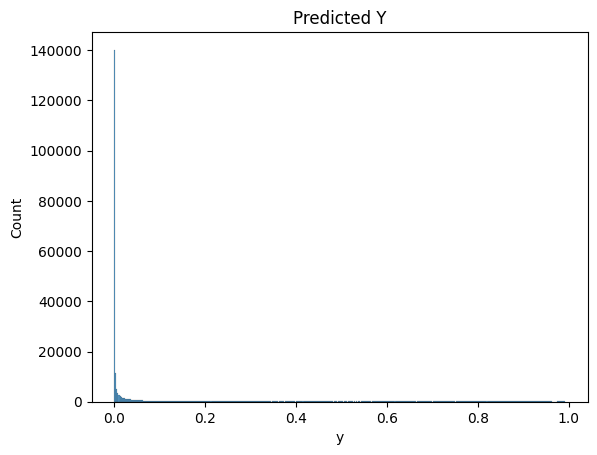

In [15]:
import seaborn as sns
sns.histplot(submission.y).set_title("Predicted Y")

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Observed Y')

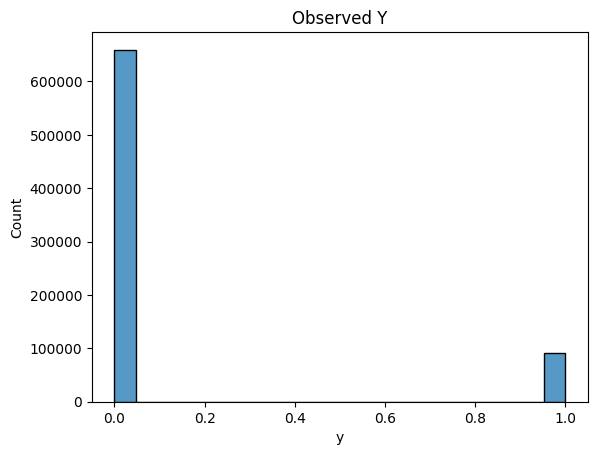

In [16]:
sns.histplot(train.y).set_title("Observed Y")

## Cleanup

Delete all the files for installing Autogluon - let's save Kaggle a bit of disk storage costs.

In [17]:
if not is_interactive_session():
    os.system("rm -rf /kaggle/working/*")
    print("Clean-up complete: deleted files from /kaggle/working/")
else:
    print("Not an interactive session. Skipping clean-up.")

Clean-up complete: deleted files from /kaggle/working/
